In [1]:
"""Learned primal-dual method for 3D cone beam reconstruction."""

import os
import adler
adler.util.gpu.setup_one_gpu()

from adler.odl.phantom import random_phantom
from adler.tensorflow import prelu, cosine_decay

import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

np.random.seed(0)
name = 'learned_primal_dual_3d_cone_beam_notebook'

sess = tf.InteractiveSession()

# Create ODL data structures for 3D
size = 32  # Reduced size for 3D due to memory constraints
space = odl.uniform_discr([-16, -16, -16], [16, 16, 16], [size, size, size],
                          dtype='float32')

# Create cone beam geometry
# Detector parameters
detector_shape = [size, size]  # 2D detector pixel array [height, width]

# Geometry parameters - typical cone beam CT setup
src_radius = 150.0  # Distance from source to rotation axis
det_radius = 50.0   # Distance from rotation axis to detector
# Total source-detector distance = src_radius + det_radius = 200.0

# Number of projection angles
num_angles = 90  # More angles needed for 3D reconstruction

# Create cone beam geometry - ODL determines detector size from space and geometry
geometry = odl.tomo.cone_beam_geometry(
    space, 
    src_radius=src_radius, 
    det_radius=det_radius,
    num_angles=num_angles,
    det_shape=detector_shape
)

operator = odl.tomo.RayTransform(space, geometry)

# Ensure operator has fixed operator norm for scale invariance
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator,
                                                          'RayTransform3D')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint,
                                                                  'RayTransformAdjoint3D')

# User selected parameters
n_data = 6  # Reduced for 3D due to memory constraints
n_iter = 15  # Slightly reduced iterations
n_primal = 5
n_dual = 5

def generate_data(validation=False):
    """Generate a set of random 3D data."""
    n_generate = 1 if validation else n_data

    # 3D projection data shape: [batch, num_angles, detector_height, detector_width, channels]
    y_arr = np.empty((n_generate, geometry.angles.size, detector_shape[0], detector_shape[1], 1), dtype='float32')
    # 3D volume shape: [batch, depth, height, width, channels]
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], space.shape[2], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            # Create a simple 3D phantom for validation
            phantom = odl.phantom.shepp_logan(space, modified=True)
        else:
            # For training, create simple 3D phantoms since random_phantom doesn't work with 3D
            # Create a combination of simple geometric shapes
            phantom = create_simple_3d_phantom(space)
        
        data = operator(phantom)
        # Add noise to the projection data
        noise_level = 0.05
        noisy_data = data + odl.phantom.white_noise(operator.range) * np.mean(np.abs(data)) * noise_level

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr


def create_simple_3d_phantom(space):
    """Create a simple 3D phantom with geometric shapes."""
    phantom = space.zero()
    
    # Get meshgrid coordinates
    coords = space.meshgrid
    x, y, z = coords
    
    # Create multiple ellipsoids with random parameters
    n_ellipsoids = np.random.randint(5, 11)  # 5-10 ellipsoids
    
    for _ in range(n_ellipsoids):
        # Random center within the volume
        center_x = np.random.uniform(-20, 20)
        center_y = np.random.uniform(-20, 20)
        center_z = np.random.uniform(-20, 20)
        
        # Random semi-axes
        a = np.random.uniform(3, 12)  # x semi-axis
        b = np.random.uniform(3, 12)  # y semi-axis
        c = np.random.uniform(3, 12)  # z semi-axis
        
        # Random intensity
        intensity = np.random.uniform(0.1, 1.0)
        
        # Create ellipsoid
        ellipsoid_mask = ((x - center_x)**2 / a**2 + 
                         (y - center_y)**2 / b**2 + 
                         (z - center_z)**2 / c**2) <= 1
        
        # Add to phantom using ODL element operations
        phantom += intensity * ellipsoid_mask
    
    # Add some noise to make it more realistic
    noise_array = np.random.normal(0, 0.02, phantom.shape)
    phantom += noise_array
    
    # Ensure non-negative values
    phantom_array = np.asarray(phantom)
    phantom_array = np.maximum(phantom_array, 0)
    
    # Create new ODL element with the processed array
    result_phantom = space.element(phantom_array)
    
    return result_phantom


with tf.name_scope('placeholders'):
    # 3D volume placeholder
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, size, 1], name="x_true")
    # 3D projection data placeholder
    y_rt = tf.placeholder(tf.float32, shape=[None, geometry.angles.size, detector_shape[0], detector_shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')


def apply_conv3d(x, filters=32, kernel_size=3):
    """Apply 3D convolution layer."""
    return tf.layers.conv3d(x, filters=filters, kernel_size=kernel_size, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())

def apply_conv2d_projections(x, filters=32, kernel_size=3):
    """Apply 2D convolution to projection data (last 2 dimensions)."""
    # Get static and dynamic shapes
    input_shape = x.get_shape().as_list()
    batch_size = tf.shape(x)[0]
    num_angles = tf.shape(x)[1]
    det_h = tf.shape(x)[2]
    det_w = tf.shape(x)[3]
    
    # Get channel dimension - use static shape if available
    if input_shape[4] is not None:
        channels = input_shape[4]
    else:
        channels = tf.shape(x)[4]
    
    # Reshape to [batch*angles, det_h, det_w, channels]
    x_reshaped = tf.reshape(x, [batch_size * num_angles, det_h, det_w, channels])
    
    # Set the shape explicitly for TensorFlow to understand the channel dimension
    if input_shape[2] is not None and input_shape[3] is not None and input_shape[4] is not None:
        x_reshaped.set_shape([None, input_shape[2], input_shape[3], input_shape[4]])
    
    # Apply 2D convolution
    conv_result = tf.layers.conv2d(x_reshaped, filters=filters, kernel_size=kernel_size, 
                                   padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
    
    # Reshape back to [batch, angles, det_h, det_w, filters]
    output_shape = [batch_size, num_angles, det_h, det_w, filters]
    return tf.reshape(conv_result, output_shape)

primal_values = []
dual_values = []

with tf.name_scope('tomography_3d'):
    with tf.name_scope('initial_values'):
        # Initialize primal (3D volume) and dual (3D projection) variables
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            # Forward projection: 3D volume -> 3D projection data
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            # Apply 2D convolutions to projection data
            update = prelu(apply_conv2d_projections(update, filters=32), name='prelu_1')
            update = prelu(apply_conv2d_projections(update, filters=32), name='prelu_2')
            update = apply_conv2d_projections(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            # Back projection: 3D projection data -> 3D volume
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            # Apply 3D convolutions to volume data
            update = prelu(apply_conv3d(update, filters=32), name='prelu_1')
            update = prelu(apply_conv3d(update, filters=32), name='prelu_2')
            update = apply_conv3d(update, filters=n_primal)
            primal = primal + update
            
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]


with tf.name_scope('loss'):
    residual = x_result - x_true
    squared_error = residual ** 2
    loss = tf.reduce_mean(squared_error)


with tf.name_scope('optimizer'):
    # Learning rate
    global_step = tf.Variable(0, trainable=False)
    maximum_steps = 5001  # Reduced steps for 3D
    starter_learning_rate = 1e-3  # Lower learning rate for 3D
    learning_rate = cosine_decay(starter_learning_rate,
                                 global_step,
                                 maximum_steps,
                                 name='learning_rate')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        opt_func = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                          beta2=0.99)

        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), 1)
        optimizer = opt_func.apply_gradients(zip(grads, tvars),
                                             global_step=global_step)


# Summaries
with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('psnr', -10 * tf.log(loss) / tf.log(10.0))

    # For 3D visualization, show middle slices
    mid_slice = size // 2
    
    # Axial slices (xy-plane) - squeeze the depth dimension
    tf.summary.image('x_result_axial', tf.squeeze(x_result[:, mid_slice:mid_slice+1, :, :, :], axis=1))
    tf.summary.image('x_true_axial', tf.squeeze(x_true[:, mid_slice:mid_slice+1, :, :, :], axis=1))
    tf.summary.image('squared_error_axial', tf.squeeze(squared_error[:, mid_slice:mid_slice+1, :, :, :], axis=1))
    
    # Coronal slices (xz-plane) - squeeze the height dimension
    tf.summary.image('x_result_coronal', tf.squeeze(x_result[:, :, mid_slice:mid_slice+1, :, :], axis=2))
    tf.summary.image('x_true_coronal', tf.squeeze(x_true[:, :, mid_slice:mid_slice+1, :, :], axis=2))
    
    # Sagittal slices (yz-plane) - squeeze the width dimension
    tf.summary.image('x_result_sagittal', tf.squeeze(x_result[:, :, :, mid_slice:mid_slice+1, :], axis=3))
    tf.summary.image('x_true_sagittal', tf.squeeze(x_true[:, :, :, mid_slice:mid_slice+1, :], axis=3))

    # Show some projection views - FIX: Squeeze the angle dimension
    mid_angle = geometry.angles.size // 2
    tf.summary.image('projection_result', tf.squeeze(y_rt[:, mid_angle:mid_angle+1, :, :, :], axis=1))

    merged_summary = tf.summary.merge_all()
    
    tb_dir = adler.tensorflow.util.default_tensorboard_dir(name)
    print(f"TensorBoard directory: {tb_dir}")
    print(f"Type: {type(tb_dir)}")
    
    test_summary_writer = tf.summary.FileWriter(tb_dir + '/test',
                                                sess.graph)
    train_summary_writer = tf.summary.FileWriter(tb_dir + '/train')

# Initialize all TF variables
sess.run(tf.global_variables_initializer())

# Add op to save and restore
saver = tf.train.Saver()

# Generate validation data
print("Generating validation data...")
y_arr_validate, x_true_arr_validate = generate_data(validation=True)
print(f"Validation data shapes: y={y_arr_validate.shape}, x={x_true_arr_validate.shape}")

if 0:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(name))

# Train the network
print("Starting training...")
for i in range(0, maximum_steps):
    if i % 20 == 0:  # Generate data less frequently for 3D
        print(f"Generating training data at step {i}...")
        y_arr, x_true_arr = generate_data()

    _, merged_summary_result_train, global_step_result = sess.run([optimizer, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr,
                                         y_rt: y_arr,
                                         is_training: True})

    if i > 0 and i % 20 == 0:  # Validate less frequently
        loss_result, merged_summary_result, global_step_result = sess.run([loss, merged_summary, global_step],
                              feed_dict={x_true: x_true_arr_validate,
                                         y_rt: y_arr_validate,
                                         is_training: False})

        train_summary_writer.add_summary(merged_summary_result_train, global_step_result)
        test_summary_writer.add_summary(merged_summary_result, global_step_result)

        print('iter={}, loss={:.6f}'.format(global_step_result, loss_result))

    if i > 0 and i % 500 == 0:  # Save less frequently
        print(f"Saving model at step {i}...")
        saver.save(sess,
                   adler.tensorflow.util.default_checkpoint_path(name))

print("Training completed!")

Picking GPU(s) 0




Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend 

Training complete. Starting 3D evaluation...
Running 3D model evaluation...
Final loss: 0.017100
Getting intermediate values for analysis...

=== DIAGNOSTIC INFORMATION ===
Ground truth shape: (32, 32, 32)
Reconstruction shape: (32, 32, 32)
Ground truth range: [-0.000000, 1.000000]
Ground truth mean±std: 0.071503 ± 0.182827
Reconstruction range: [-0.096714, 0.528374]
Reconstruction mean±std: 0.076366 ± 0.115300

3D Volume SSIM: 0.4917
3D Volume PSNR: 17.67 dB
Using display range: [-0.118648, 1.021934]
Creating comprehensive comparison...


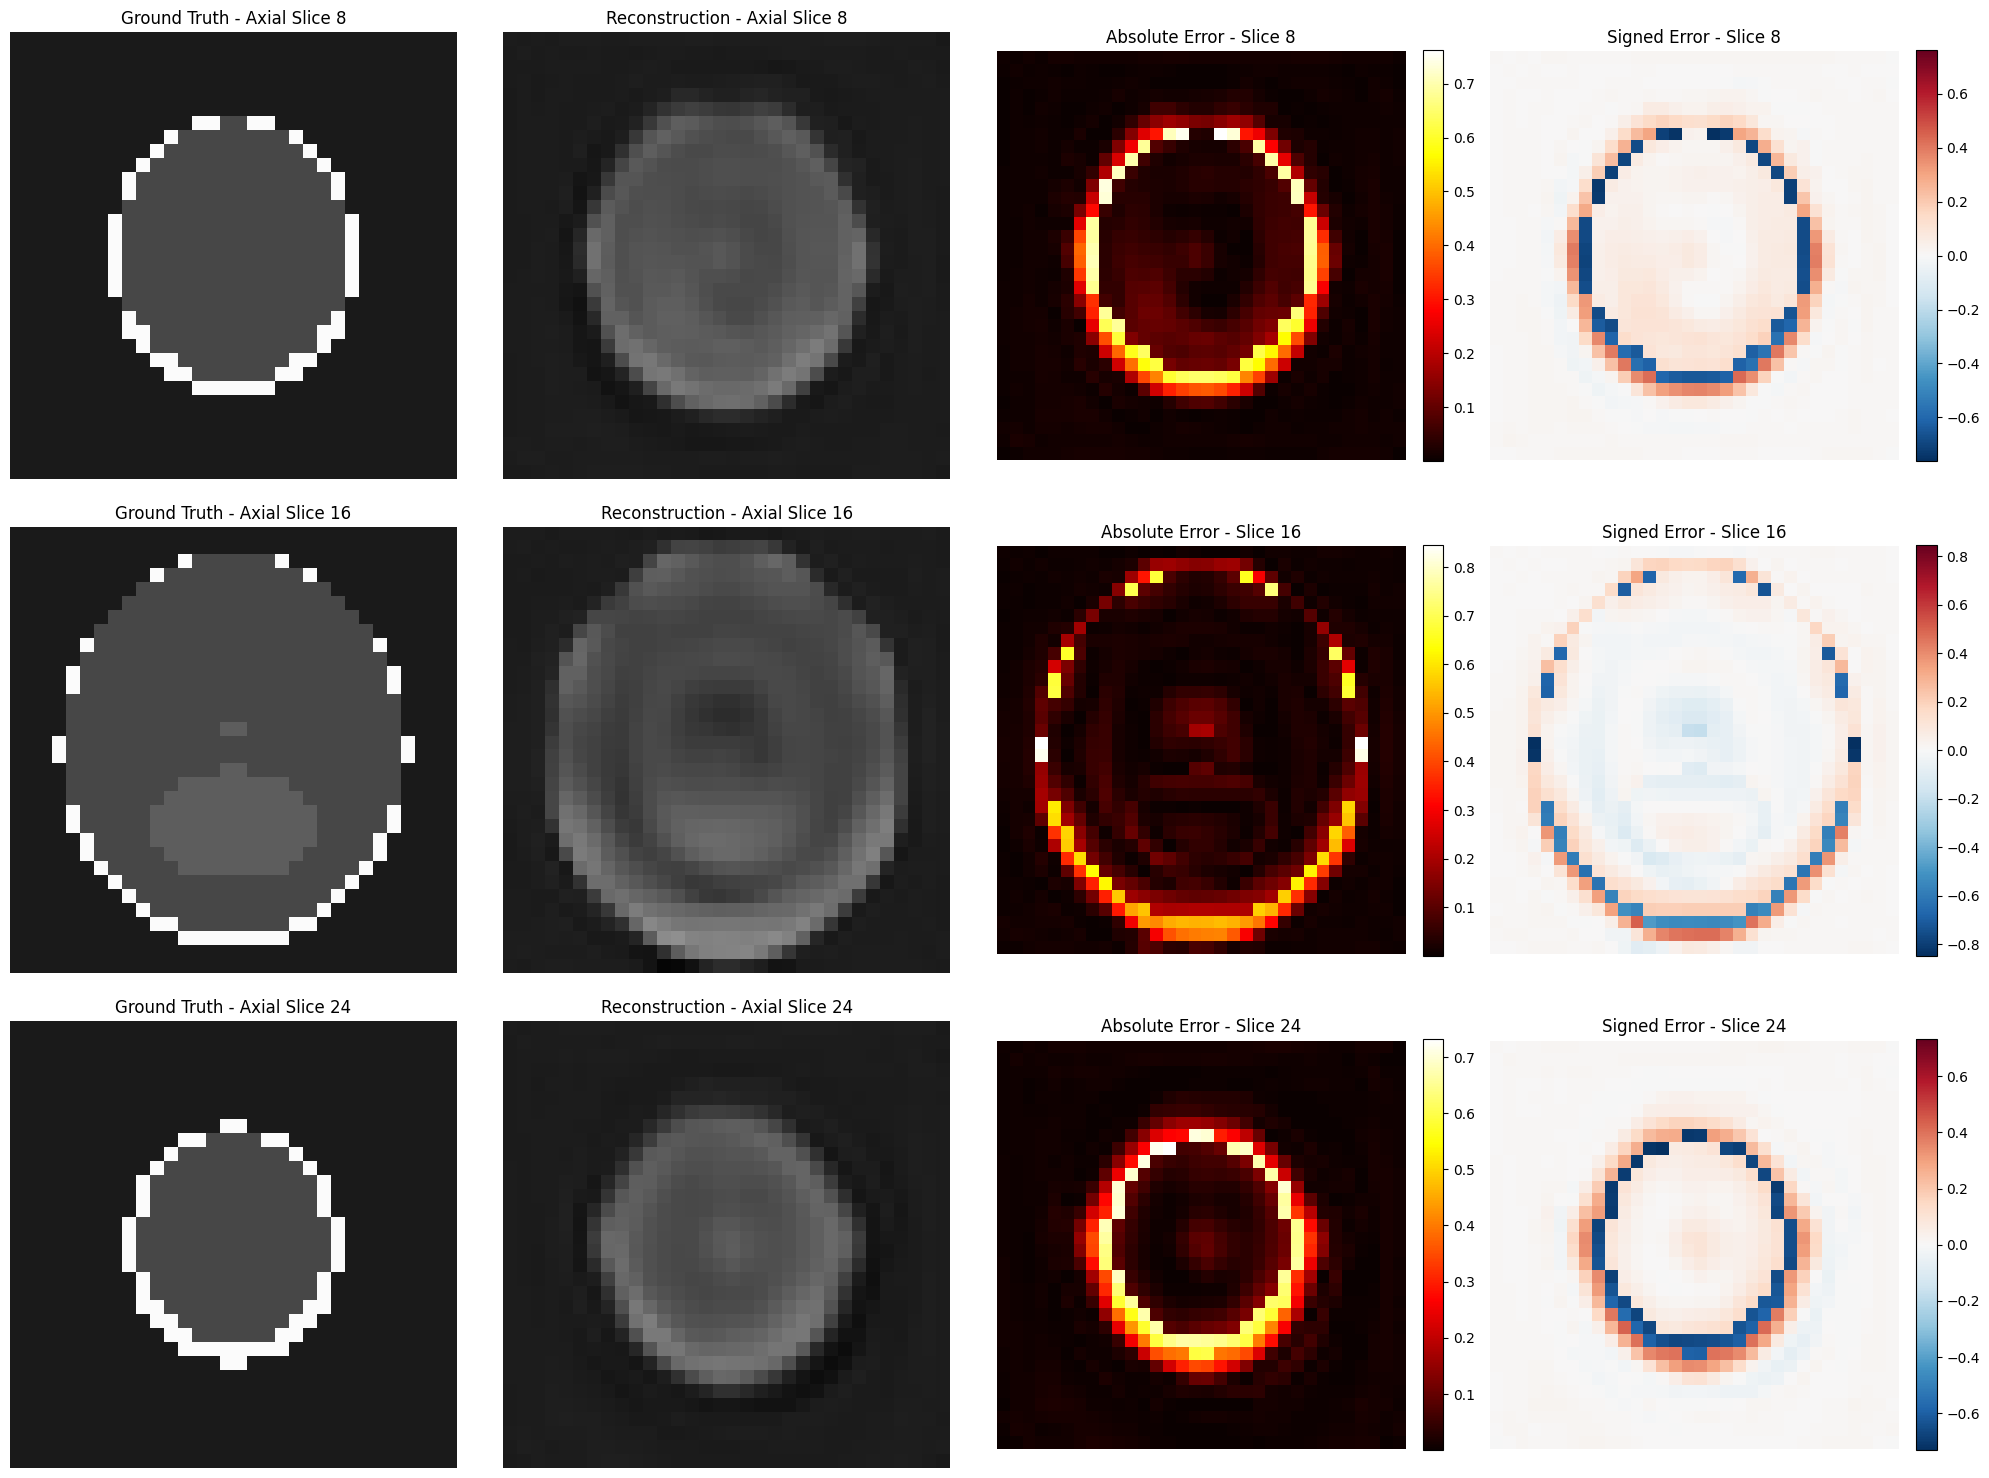

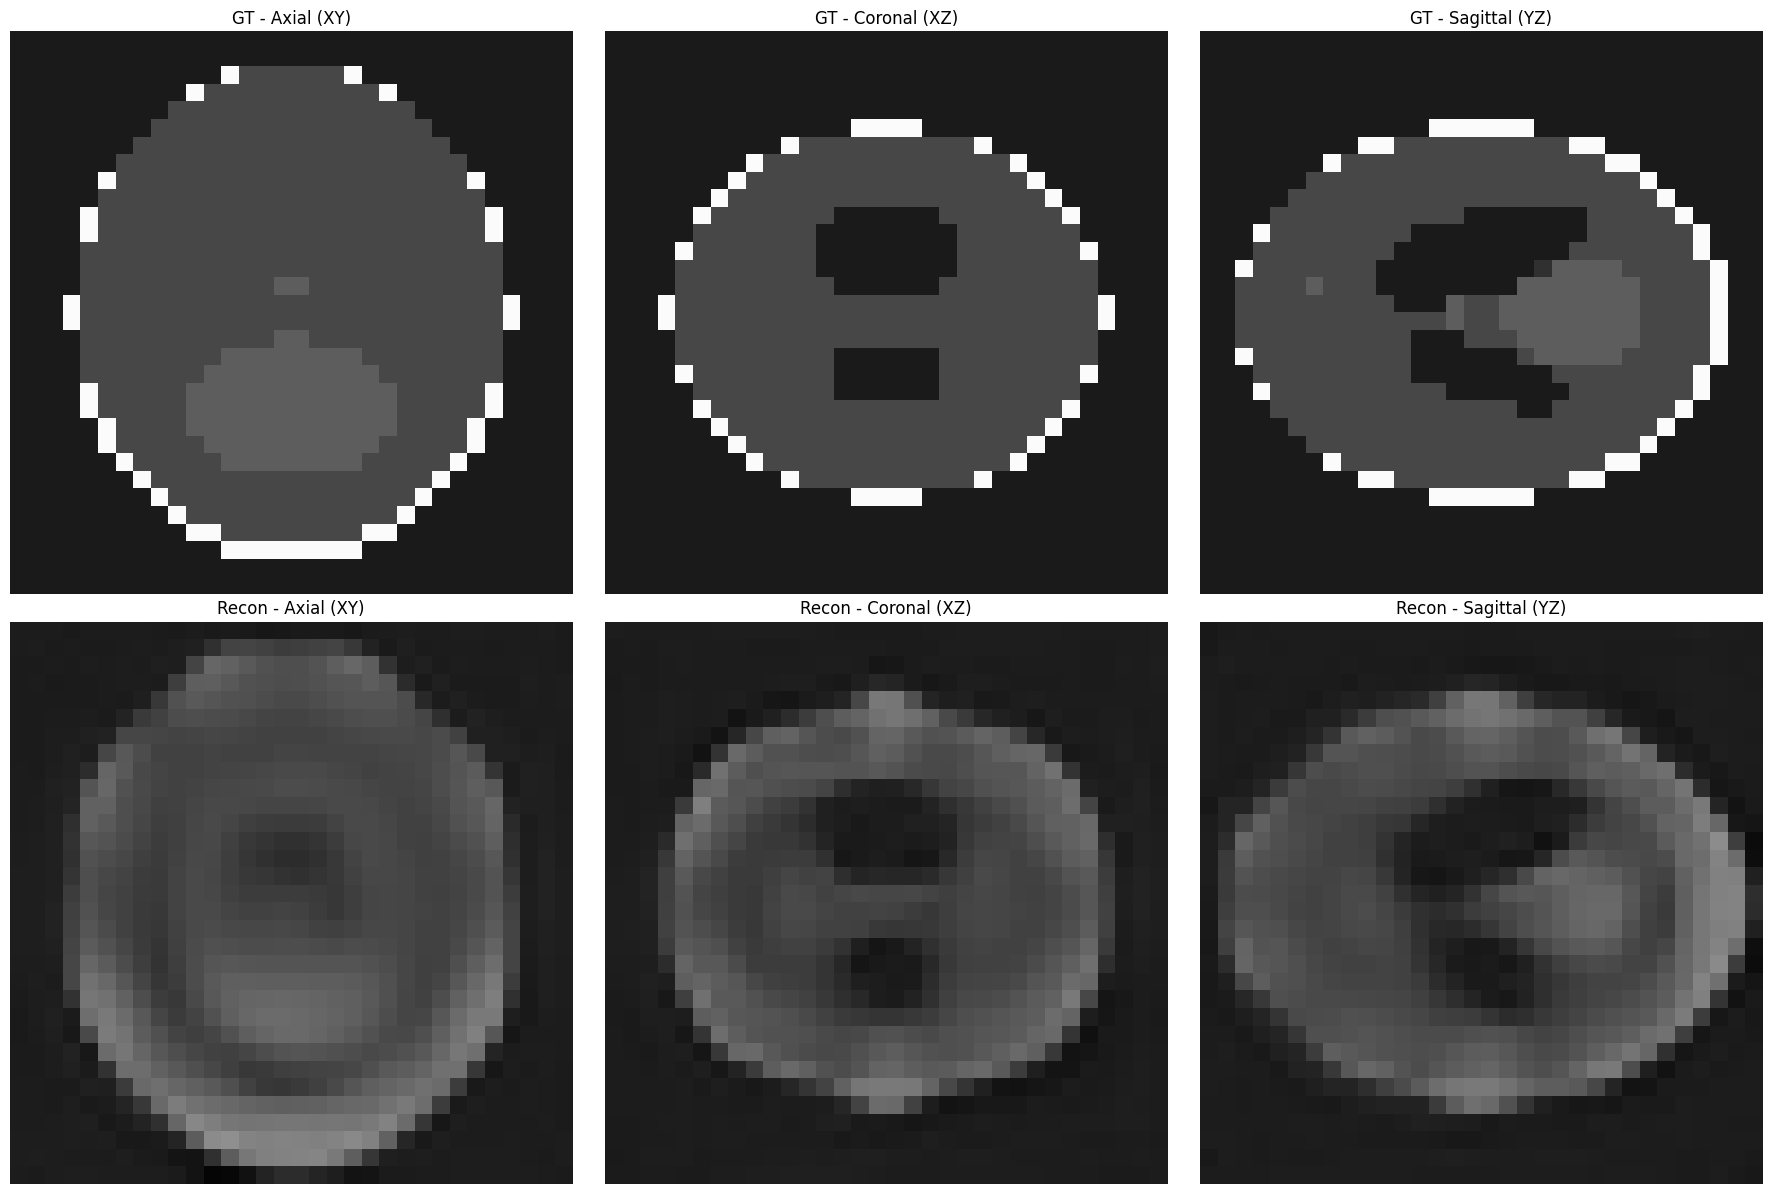

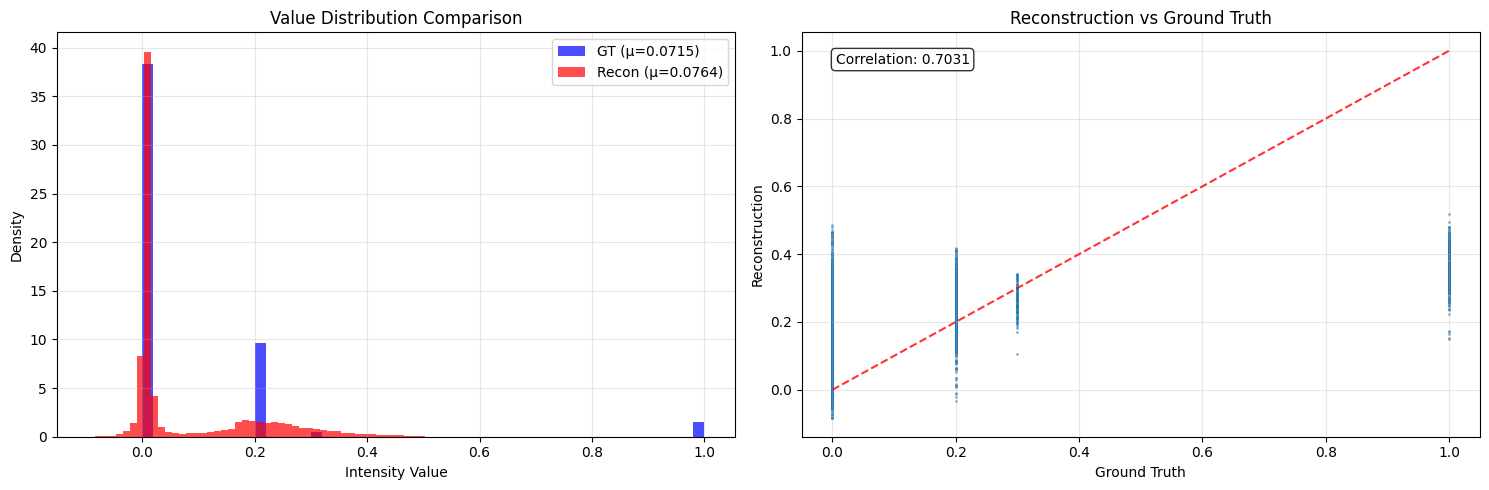

Analyzing convergence...


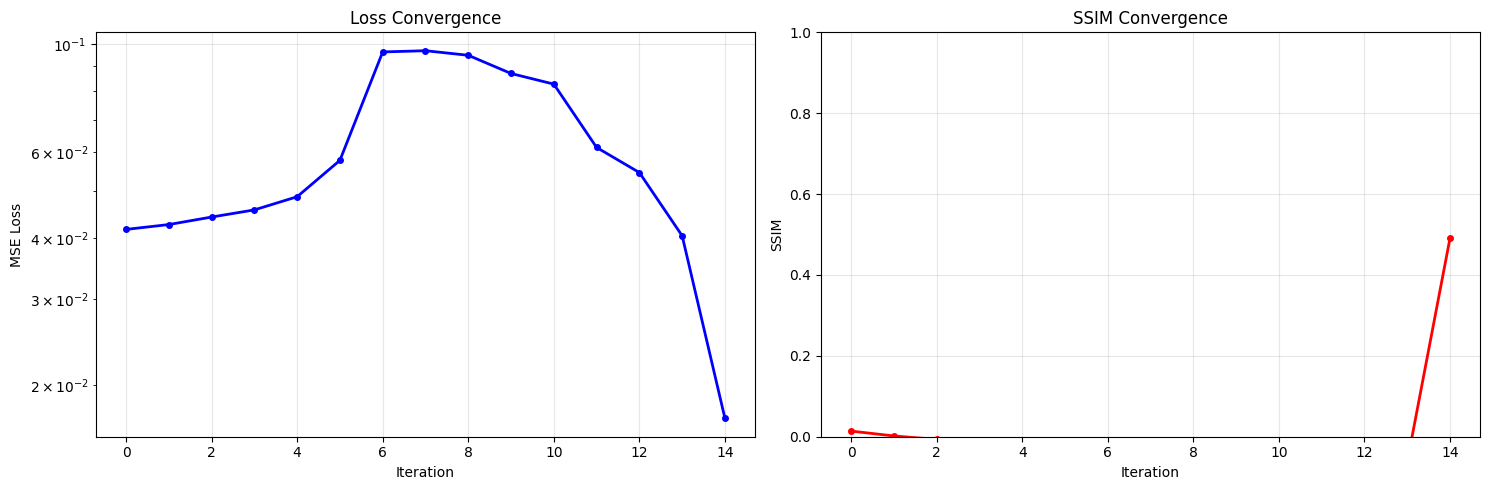

Loss reduction: 59.0%

Slice-wise analysis:
Axial slice 0: SSIM=0.544, PSNR=40.4dB
Axial slice 4: SSIM=0.527, PSNR=28.0dB
Axial slice 8: SSIM=0.375, PSNR=15.6dB
Axial slice 12: SSIM=0.501, PSNR=16.0dB
Axial slice 16: SSIM=0.485, PSNR=16.3dB
Axial slice 20: SSIM=0.475, PSNR=15.9dB
Axial slice 24: SSIM=0.385, PSNR=15.7dB
Axial slice 28: SSIM=0.494, PSNR=39.3dB

=== FINAL RESULTS ===
Overall 3D Volume SSIM: 0.4917
Overall 3D Volume PSNR: 17.67 dB
Mean Axial SSIM: 0.4731 ± 0.0577
Mean Axial PSNR: 23.39 ± 10.28 dB
Pixel-wise correlation: 0.7031
Results saved to: learned_primal_dual_3d_cone_beam_notebook_3d_results/

✅ Reconstruction quality appears reasonable
3D evaluation completed!


In [2]:
# FIXED evaluation code for 3D cone beam reconstruction

print("Training complete. Starting 3D evaluation...")

# Generate validation data (if not already done)
if 'y_arr_validate' not in locals() or 'x_true_arr_validate' not in locals():
    print("Generating validation data...")
    y_arr_validate, x_true_arr_validate = generate_data(validation=True)

try:
    # CRITICAL FIX 1: Run the final reconstruction, not intermediate values
    print("Running 3D model evaluation...")
    
    # Get the final reconstruction result
    final_reconstruction, loss_value = sess.run([x_result, loss],
                              feed_dict={x_true: x_true_arr_validate,
                                         y_rt: y_arr_validate,
                                         is_training: False})
    
    print(f"Final loss: {loss_value:.6f}")
    
    # OPTIONAL: Get intermediate values for convergence analysis
    print("Getting intermediate values for analysis...")
    primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                          feed_dict={x_true: x_true_arr_validate,
                                     y_rt: y_arr_validate,
                                     is_training: False})
    
    # Import required libraries
    import matplotlib.pyplot as plt
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr
    
    # CRITICAL FIX 2: Use the correct final result
    final_result = final_reconstruction[0, ..., 0]  # Shape: [depth, height, width]
    ground_truth = x_true_arr_validate[0, ..., 0]   # Shape: [depth, height, width]
    
    # DIAGNOSTIC: Check data ranges and identify issues
    print("\n=== DIAGNOSTIC INFORMATION ===")
    print(f"Ground truth shape: {ground_truth.shape}")
    print(f"Reconstruction shape: {final_result.shape}")
    print(f"Ground truth range: [{ground_truth.min():.6f}, {ground_truth.max():.6f}]")
    print(f"Ground truth mean±std: {ground_truth.mean():.6f} ± {ground_truth.std():.6f}")
    print(f"Reconstruction range: [{final_result.min():.6f}, {final_result.max():.6f}]")
    print(f"Reconstruction mean±std: {final_result.mean():.6f} ± {final_result.std():.6f}")
    
    # Check for common issues
    if final_result.max() < 0.01:
        print("⚠️  WARNING: Reconstruction values are very small - possible scaling issue!")
    if np.std(final_result) < 0.001:
        print("⚠️  WARNING: Reconstruction has very low contrast - network may not be learning!")
    if np.any(np.isnan(final_result)):
        print("❌ ERROR: NaN values detected in reconstruction!")
    if np.all(final_result == final_result.flat[0]):
        print("❌ ERROR: Reconstruction is constant - network completely failed!")
    
    # CRITICAL FIX 3: Use proper data range for metrics
    data_range = max(ground_truth.max() - ground_truth.min(), 
                    final_result.max() - final_result.min())
    
    if data_range > 0:
        ssim_value = ssim(final_result, ground_truth, data_range=data_range)
        psnr_value = psnr(final_result, ground_truth, data_range=data_range)
        print(f"\n3D Volume SSIM: {ssim_value:.4f}")
        print(f"3D Volume PSNR: {psnr_value:.2f} dB")
    else:
        print("❌ ERROR: Zero data range - cannot calculate SSIM/PSNR")
        ssim_value = 0
        psnr_value = 0
    
    # Create output directory
    import os
    path = name + '_3d_results'
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    
    # CRITICAL FIX 4: Use consistent display ranges for all visualizations
    # Calculate proper display range
    combined_min = min(ground_truth.min(), final_result.min())
    combined_max = max(ground_truth.max(), final_result.max())
    
    # Add some padding to avoid edge effects
    range_padding = (combined_max - combined_min) * 0.02
    display_min = combined_min - range_padding
    display_max = combined_max + range_padding
    
    print(f"Using display range: [{display_min:.6f}, {display_max:.6f}]")
    
    # Define slice indices for visualization
    mid_slice = size // 2
    slice_indices = [size//4, mid_slice, 3*size//4]
    
    # IMPROVED: Create comprehensive comparison first
    print("Creating comprehensive comparison...")
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    for i, slice_idx in enumerate(slice_indices):
        if slice_idx < ground_truth.shape[0]:
            # Ground truth
            axes[i, 0].imshow(ground_truth[slice_idx, :, :], cmap='gray', 
                            vmin=display_min, vmax=display_max)
            axes[i, 0].set_title(f'Ground Truth - Axial Slice {slice_idx}')
            axes[i, 0].axis('off')
            
            # Reconstruction
            axes[i, 1].imshow(final_result[slice_idx, :, :], cmap='gray', 
                            vmin=display_min, vmax=display_max)
            axes[i, 1].set_title(f'Reconstruction - Axial Slice {slice_idx}')
            axes[i, 1].axis('off')
            
            # Absolute error
            error = np.abs(final_result[slice_idx, :, :] - ground_truth[slice_idx, :, :])
            im1 = axes[i, 2].imshow(error, cmap='hot')
            axes[i, 2].set_title(f'Absolute Error - Slice {slice_idx}')
            axes[i, 2].axis('off')
            plt.colorbar(im1, ax=axes[i, 2], fraction=0.046, pad=0.04)
            
            # Difference (signed error)
            diff = final_result[slice_idx, :, :] - ground_truth[slice_idx, :, :]
            im2 = axes[i, 3].imshow(diff, cmap='RdBu_r', 
                                  vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
            axes[i, 3].set_title(f'Signed Error - Slice {slice_idx}')
            axes[i, 3].axis('off')
            plt.colorbar(im2, ax=axes[i, 3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig(f'{path}/comprehensive_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # IMPROVED: Multi-view comparison for middle slice
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Ground truth views
    axes[0, 0].imshow(ground_truth[mid_slice, :, :], cmap='gray', vmin=display_min, vmax=display_max)
    axes[0, 0].set_title('GT - Axial (XY)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ground_truth[:, mid_slice, :], cmap='gray', vmin=display_min, vmax=display_max)
    axes[0, 1].set_title('GT - Coronal (XZ)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(ground_truth[:, :, mid_slice], cmap='gray', vmin=display_min, vmax=display_max)
    axes[0, 2].set_title('GT - Sagittal (YZ)')
    axes[0, 2].axis('off')
    
    # Reconstruction views
    axes[1, 0].imshow(final_result[mid_slice, :, :], cmap='gray', vmin=display_min, vmax=display_max)
    axes[1, 0].set_title('Recon - Axial (XY)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(final_result[:, mid_slice, :], cmap='gray', vmin=display_min, vmax=display_max)
    axes[1, 1].set_title('Recon - Coronal (XZ)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(final_result[:, :, mid_slice], cmap='gray', vmin=display_min, vmax=display_max)
    axes[1, 2].set_title('Recon - Sagittal (YZ)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{path}/multiview_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Value distribution comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.hist(ground_truth.flatten(), bins=50, alpha=0.7, color='blue', 
             label=f'GT (μ={ground_truth.mean():.4f})', density=True)
    ax1.hist(final_result.flatten(), bins=50, alpha=0.7, color='red', 
             label=f'Recon (μ={final_result.mean():.4f})', density=True)
    ax1.set_title('Value Distribution Comparison')
    ax1.set_xlabel('Intensity Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot
    gt_flat = ground_truth.flatten()
    recon_flat = final_result.flatten()
    
    # Sample points for faster plotting
    n_sample = min(10000, len(gt_flat))
    idx_sample = np.random.choice(len(gt_flat), n_sample, replace=False)
    
    ax2.scatter(gt_flat[idx_sample], recon_flat[idx_sample], alpha=0.5, s=1)
    ax2.plot([gt_flat.min(), gt_flat.max()], [gt_flat.min(), gt_flat.max()], 'r--', alpha=0.8)
    ax2.set_xlabel('Ground Truth')
    ax2.set_ylabel('Reconstruction')
    ax2.set_title('Reconstruction vs Ground Truth')
    ax2.grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(gt_flat, recon_flat)[0, 1]
    ax2.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{path}/distribution_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Convergence analysis (if intermediate values available)
    if len(primal_values_result) > 1:
        print("Analyzing convergence...")
        
        iteration_losses = []
        iteration_ssims = []
        
        for i in range(len(primal_values_result)):
            iter_result = primal_values_result[i][0, ..., 0]  # Get first channel
            iter_loss = np.mean((iter_result - ground_truth)**2)
            iteration_losses.append(iter_loss)
            
            if data_range > 0:
                iter_ssim = ssim(iter_result, ground_truth, data_range=data_range)
                iteration_ssims.append(iter_ssim)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss convergence
        ax1.plot(range(len(iteration_losses)), iteration_losses, 'b-o', linewidth=2, markersize=4)
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('MSE Loss')
        ax1.set_title('Loss Convergence')
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # SSIM convergence
        if iteration_ssims:
            ax2.plot(range(len(iteration_ssims)), iteration_ssims, 'r-o', linewidth=2, markersize=4)
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('SSIM')
            ax2.set_title('SSIM Convergence')
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig(f'{path}/convergence_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"Loss reduction: {((iteration_losses[0] - iteration_losses[-1]) / iteration_losses[0] * 100):.1f}%")
    
    # Slice-wise analysis with proper error handling
    print("\nSlice-wise analysis:")
    axial_ssims = []
    axial_psnrs = []
    
    for z in range(0, size, max(1, size//8)):  # Ensure step is at least 1
        if z < ground_truth.shape[0] and data_range > 0:
            try:
                slice_ssim = ssim(final_result[z, :, :], ground_truth[z, :, :], data_range=data_range)
                slice_psnr = psnr(final_result[z, :, :], ground_truth[z, :, :], data_range=data_range)
                axial_ssims.append(slice_ssim)
                axial_psnrs.append(slice_psnr)
                print(f"Axial slice {z}: SSIM={slice_ssim:.3f}, PSNR={slice_psnr:.1f}dB")
            except Exception as e:
                print(f"Error processing slice {z}: {e}")
    
    # Final summary
    print(f"\n=== FINAL RESULTS ===")
    print(f"Overall 3D Volume SSIM: {ssim_value:.4f}")
    print(f"Overall 3D Volume PSNR: {psnr_value:.2f} dB")
    if axial_ssims:
        print(f"Mean Axial SSIM: {np.mean(axial_ssims):.4f} ± {np.std(axial_ssims):.4f}")
        print(f"Mean Axial PSNR: {np.mean(axial_psnrs):.2f} ± {np.std(axial_psnrs):.2f} dB")
    print(f"Pixel-wise correlation: {correlation:.4f}")
    print(f"Results saved to: {path}/")
    
    # CRITICAL: Check if reconstruction is meaningful
    if ssim_value < 0.1:
        print("\n❌ RECONSTRUCTION QUALITY IS VERY POOR!")
        print("Possible issues:")
        print("- Network architecture problems (wrong convolution types)")
        print("- Insufficient training")
        print("- Wrong data preprocessing")
        print("- Numerical instabilities")
    elif ssim_value < 0.3:
        print("\n⚠️  RECONSTRUCTION QUALITY IS LOW")
        print("Consider:")
        print("- More training iterations")
        print("- Better network architecture")
        print("- More projection angles")
    else:
        print("\n✅ Reconstruction quality appears reasonable")
    
except Exception as e:
    print(f"Error during 3D evaluation: {str(e)}")
    import traceback
    traceback.print_exc()
    print("Make sure the model has been trained and the session is still active")

print("3D evaluation completed!")